In [17]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.firefox import GeckoDriverManager
import spacy
import time
import os
from langdetect import detect
import nltk
import csv
import ast
import timeit
import pandas as pd
import math
import heapq
import matplotlib.pyplot as plt

In [2]:
href = "https://www.goodreads.com/list/show/1.Best_Books_Ever?page=1"
driver = webdriver.Firefox(executable_path = GeckoDriverManager().install())

[WDM] - Getting latest mozilla release info for v0.28.0
[WDM] - Trying to download new driver from https://github.com/mozilla/geckodriver/releases/download/v0.28.0/geckodriver-v0.28.0-linux64.tar.gz
[WDM] - Driver has been saved in cache [/home/michele/.wdm/drivers/geckodriver/linux64/v0.28.0]


#### These three cells load the vocabulary and the dictionaries from text files, run them only if you have already created them with new_vocabulary(), update_dictionary() and update_dictionart_tfidf() functions.

In [18]:
file = open("vocabulary.txt", "r")
vocabulary = next(file)
file.close()
vocabulary = ast.literal_eval(vocabulary)

In [11]:
file = open("dictionary.txt", "r")
dictionary = next(file)
file.close()
dictionary = ast.literal_eval(dictionary)

In [19]:
file = open("dictionary2.txt", "r")
dictionary2 = next(file)
file.close()
dictionary2 = ast.literal_eval(dictionary2)

In [130]:
def get_urls(href, driver, pages_num):
    
    href = href[0:-1]
    
    file = open("urls.txt", "w")
    
    for i in range(1, pages_num + 1):
        
        new_href = href + str(i)
        driver.get(new_href)
        page_soup = BeautifulSoup(driver.page_source, features="lxml")
        links_list = page_soup.find_all("a", {'class' : 'bookTitle'}, itemprop = "url")
        
        for link in links_list:
            url = link.get("href")
            file.write("https://www.goodreads.com" + url + "\n")
        
        print(" | "+str(i), end = "")
            
    file.close()

In [131]:
#Don't run this cell! It delete and rewrite urls.txt and it takes time.
#get_urls(href, driver, 300)

In [ ]:
def download_htmls(href, driver):
    
    urls_file = open("urls.txt", "r")
    urls_count = 1
    num_page = 1
    
    for url in urls_file:
        
        if (urls_count % 100) == 0:
            num_page += 1
            os.mkdir("page" + str(num_page))
        
        driver.get(url)
        
        file = open("page"+str(num_page)+"/"+"article_"+str(urls_count+1)+".html", "w")
        file.write(driver.page_source)
        file.close()
        
        urls_count += 1
        print(" | "+str(urls_count), end = "")
            
    urls_file.close()

In [4]:
# Download 30000 html. Already done.
#download_htmls(href, driver)

In [1]:
def extract_books_informations():
    
    urls_list = list(open("urls.txt", "r"))
    from_page = 1
    to_page = 300
    bf = []
    
    for num_page in range(from_page, to_page+1):
        
        from_html = ((num_page-1) * 100) + 1
        to_html = (num_page * 100) + 1
        
        for current_html in range(from_html, to_html):
            webpage = open("page"+str(num_page)+"/article_"+str(current_html)+".html")
            soup = BeautifulSoup(webpage, features = "lxml")
            
            # Sometimes the funcition download_htmls doesn't work well and the html pages are without the fields
            # we needed (title, plot ecc), for this reason we use a "try" before taking the title, in case of
            # an error, we append the "broken file" in the bf list so that we'll be able to download it again.
            try:
                #TITLE
                bookTitle = soup.find_all("h1", id = "bookTitle")[0].contents[0].strip()
            except:
                print(" | " + str(current_html)+" Unexpected broken file")
                bf.append(current_html)
                continue
            
            #SERIES
            bookSeries = soup.find_all("h2", id = "bookSeries")[0].find_all("a")
            if bookSeries:
                bookSeries = bookSeries[0].contents[0].strip("\n ()")
                if bookSeries != "":  
                    if bookSeries[-1].isnumeric():
                        bookSeries = bookSeries.strip(" "+str(bookSeries[-1])+"#")
            else:
                bookSeries = ""
            
            #AUTHOR
            #In the <a> link there is a <span> with the author's name inside
            bookAuthors = soup.find_all("a", {'class' : 'authorName'})[0].contents[0].contents[0].strip()
            
            #RATING VALUE
            ratingValue = soup.find_all("span", itemprop = "ratingValue")[0].contents[0].strip()
            ratingValue = float(ratingValue)
            
            #RATING COUNT
            ratingCount = soup.find_all("meta", itemprop = "ratingCount")[0]["content"]
            ratingCount = int(ratingCount)
            
            #REVIEW COUNT
            reviewCount = soup.find_all("meta", itemprop = "reviewCount")[0]["content"]
            reviewCount = int(reviewCount)
            
            #PLOT
            plot = soup.find_all("div", id = "description")
            if len(plot) == 0:
                plot = ""
            else:
                plot = plot[0].find_all("span")
                if(len(plot) == 1):
                    plot = plot[0].get_text(separator = " ").strip(" \n'\"").replace("\n", "")
                else:
                    plot = plot[1].get_text(separator = " ").strip(" \n'\"").replace("\n", "")
                try:
                    if detect(plot) != "en":
                        continue
                except:
                    print("NO_PLOT\n")
                    continue
            #NUMBER OF PAGES
            numberOfPages = soup.find_all("span", itemprop = "numberOfPages")
            if(len(numberOfPages) == 0):
                numberOfPages = ""
            else:
                numberOfPages = numberOfPages[0].contents[0].strip(" pages")
                numberOfPages = int(numberOfPages)
            
            #PUBLISHING DATE
            publishingDate = soup.find_all("div", id = "details")[0].find_all("div", {"class" : "row"})
            if len(publishingDate) == 0:
                publishingDate = ""
            else:
                if len(publishingDate[0].find_all("span")) != 0:
                    if len(publishingDate) == 1:
                        publishingDate = ""
                    else:
                        publishingDate = publishingDate[1].contents[0].strip("\n ").split("\n")
                else:
                    publishingDate = publishingDate[0].contents[0].strip("\n ").split("\n")
                if len(publishingDate) <= 1:
                    publishingDate = ""
                else:
                    publishingDate = publishingDate[1].strip()

            #CHARACTERS
            all_links = soup.find_all("div", id = "bookDataBox")[0].find_all("a")
            characters = ""
            for link in all_links:
                if "/characters/" in link["href"]:
                    characters += link.contents[0].strip() + ", "
            characters = characters.strip(", ")
            
            #PLACES
            all_links = soup.find_all("div", id = "bookDataBox")[0].find_all("a")
            places = ""
            for link in all_links:
                if "/places/" in link["href"]:
                    places += link.contents[0].strip() + ", "
            places = places.strip(", ")
            
            #URL
            url = urls_list[current_html-1]
            
            #FILE tsv
            article = open("articles/article_" +str(current_html)+".tsv", "w")
            
            article.write("bookTitle\tbookSeries\tbookAuthors\tratingValue\tratingCount\treviewCount\tplot\tnumberOfPages\tpublishingDate\tcharacters\tplaces\turl\n")

            article.write(bookTitle+"\t"+bookSeries+"\t"+bookAuthors+"\t"+str(ratingValue)+"\t"+str(ratingCount)+"\t"+str(reviewCount)+"\t"+plot+"\t"+str(numberOfPages)+"\t"+publishingDate+"\t"+characters+"\t"+places+"\t"+url)
            
            article.close()
            
            webpage.close()
            
            print(" | " + str(current_html), end = "")
            
        return bf

In [26]:
#bf = extract_books_informations()

### 2. Search Engine

In [3]:
# Takes a string in input and return a new stemmed string with no punctuation and no stopwords. 
def process_plot(plot):
    
    # Removing punctuation
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(plot.lower())
    
    # Removing stopwords
    new_plot = [word for word in tokens if not word in nltk.corpus.stopwords.words("english")]
    
    # Stemming
    stemmer = nltk.stem.porter.PorterStemmer()
    singles = [stemmer.stem(word) for word in new_plot]
    
    new_plot = ' '.join(singles)
    
    return new_plot

In [7]:
# This function takes all the articles (.tsv) and transforms their plot with the process_plot function above, 
# then saves the new processed plot on a new column called "processedPlot"

def process_articles():
    
    files_number = 30000

    for i in range(1, files_number+1):
        
        
        # Some articles are missing (for example those that are not in English), in these cases we 
        # just skip them.
        try:
            file = open("articles/article_"+str(i)+".tsv", "r")
        except:
            continue

        reader = csv.reader(file, delimiter="\t")

        lines = list(reader)

        plot = lines[1][6]

        lines[0].append("processedPlot")
        lines[1].append(process_plot(plot))

        file.close()
        file = open("articles/article_"+str(i)+".tsv", "w")

        writer = csv.writer(file, delimiter="\t")
        writer.writerows(lines)

        file.close()
        
    print("Done.")

In [14]:
process_articles()

Done.


### 2.1. Conjunctive query

In [9]:
# This function takes all the words of all the articles and map each word to a number (with the use of a 
# dictionary) then save the vocabulary into a txt file.
def new_vocabulary():
    
    vocabulary = {}
    
    num_articles = 30000
    term_id = 0
    
    for doc_i in range(1, num_articles+1):
        try:
            article = open("articles/article_"+str(doc_i)+".tsv", "r")
        except:
            continue
        reader = csv.reader(article, delimiter="\t")
        # converts a tsv file into a list of 2 elements. The first element is the list of columns names (useless),
        # the second element is the list of values.
        lines = list(reader)
        # lines[1][12] contains the "processed plot"
        plot = lines[1][12].split()

        for word in plot:
            if word not in vocabulary:
                vocabulary[word] = term_id
                term_id += 1
                
    file = open("vocabulary.txt", "w")
    file.write(str(vocabulary))
    file.close()

    print("Done.")

    return vocabulary

In [118]:
vocabulary = new_vocabulary()

Done.


In [120]:
# This function is used to update the dictionary (or create a new one if we do not pass an existing dictionary)
# Each key is a term_id and the values are the documents that contains the term
def update_dictionary(vocabulary, dictionary = {}):
    
    num_articles = 30000
    
    for doc_i in range(1, num_articles+1):
        try:
            article = open("articles/article_"+str(doc_i)+".tsv", "r")
        except:
            continue
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        # get the "processed plot"
        plot = lines[1][12].split()

        for word in plot:
            term_id = vocabulary[word]
            if term_id not in dictionary:
                dictionary[term_id] = []
            if doc_i not in dictionary[term_id]:
                dictionary[term_id].append(doc_i)
    
    file = open("dictionary.txt", "w")
    file.write(str(dictionary))
    file.close()
    
    print("Done.")
    
    return dictionary

In [121]:
dictionary = update_dictionary(vocabulary)

Done.


In [89]:
# This is an unofficial search version, use sets to get the intersection between the documents list
def search2(query, vocabulary, dictionary):
    
    # Start timer
    start = time.time()
    
    # If the query is empty, return an empty set
    if query == "":
        return set()
    
    # We need to process also the query
    query = process_plot(query)
    
    result = []
    
    # I want only the documents that contain at least one query word
    docs = []
    tokens = query.split()
    for token in tokens:
        token_id = vocabulary[token]
        if token_id in dictionary:
            docs.append(set(dictionary[token_id]))
        else:
            docs.append(set())
    
    # initialize the result with the first document list
    res = set(docs[0])
    # let's do the sets intersection
    for i in range(1, len(docs)):
        res = res.intersection(docs[i])
    
    # Stop time
    end = time.time()
    
    seconds = (end - start)
    
    # Print all the books found
    print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
    l = 1
    for doc_i in res:
        article = open("articles/article_"+str(doc_i)+".tsv", "r")
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        title = lines[1][0]
        plot = lines[1][6]
        url = lines[1][11]
        print("====== " +'\033[91m' + "Book n." + str(l) +'\033[0m' + " ======\n")
        print('\033[1m' + "Title : " + '\033[0m' + title + "\n")
        print('\033[1m' + "Plot : " + '\033[0m' + plot + "\n")
        print('\033[1m' + "url :" + '\033[0m', end = " ")
        print(url + "\n")
        l += 1

In [60]:
search2("survival games", vocabulary, dictionary)


About 122 results (0.004 seconds)

====== Book n.1 ======

Title : The Hunger Games

Plot : Could you survive on your own in the wild, with every one out to make sure you don't live to see the morning? In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and one girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV. Sixteen-year-old Katniss Everdeen, who lives alone with her mother and younger sister, regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanity and life against 

#### In this algortithm we want to compare, for each word, the documents that contain it. To do this, we scroll in parallel the lists of documents of each word and if we find the same number in all the lists we keep this value in a new list, instead if the numbers are different we add by 1 all the indices of the documents lower than the maximum document.
#### Below we show an example of how this algorithm works.

```
word1 = [1, 2, 5, 7, 10] 
word2 = [1, 3, 5, 10, 12, 13] 
word3 = [1, 3, 4, 5, 10, 11] 
index = [0, 0, 0] 
result = [] 

word1[0] == word2[0] == word3[0]
result = [1]
index = [1, 1, 1]

word1[1] < word2[1] == word3[1]
result = [1]
index = [2, 1, 1]

word1[2] > word2[1] == word3[1]
result = [1]
index = [2, 2, 2]

word1[2] == word2[2] > word3[2]
result = [1]
index = [2, 2, 3]

word1[2] == word2[2] == word3[3]
result = [1, 5]
index = [3, 3, 4]

word1[3] < word2[3] == word3[4]
result = [1, 5]
index = [4, 3, 4]

word1[4] == word2[3] == word3[4]
result = [1, 5, 10]
index = [5, 4, 5]

word1[5] > len(word1) => STOP
```

In [10]:
# Official search, it use the algorithm explained in class and above
def search(query, vocabulary, dictionary):
    
    start = time.time()
    
    # If the query is empty, print that there are no results and then stop the function
    if query == "":
        res = []
        end = time.time()
        seconds = end - start
        print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
        return
    
    # Process the query removing stopwords, punctuation and by stemming
    query = process_plot(query)
    print(query)
    
    # I want only the documents that contain at least one query word
    docs_list = []
    tokens = query.split()
    for token in tokens:
        if token in vocabulary:
            token_id = vocabulary[token]
            if token_id in dictionary:
                docs_list.append(dictionary[token_id])
            else:
                docs_list.append([])
        else:
            docs_list.append([])

    res = []
    
    # Initialize a list of indices, one for each list of documents so that I can scroll them
    n = len(docs_list)
    index = [0]*n
    
    # This list is useful to know if I have checked all the elements of a list
    # in this case I have to stop the algorithm
    lists_len = [len(docs) for docs in docs_list]
    
    run = True
    
    
    # If for a given word there are no documents that contain it, then run = False, and res is an empty list
    for doc in docs_list:
        if doc == []:
            run = False
            
    while run:
        
        # Comp keeps the documents I want to compare
        comp = []
        for i in range(n):
            comp.append(docs_list[i][index[i]])
        
        
        # I compare the documents that are in comp list. If even one of them is greater than 
        # the largest document, then I can conclude that the documents are not equal and therefore 
        # I increase by 1 all the indices of the documents smaller than the maximum
        max_comp = max(comp)
        equal = True
        for j in range(len(comp)):
            if comp[j] < max_comp:
                equal = False
                index[j] += 1
                
        # If all the documents are equal it means that contain all the words, I can insert the 
        # document number in the result list
        if equal:
            res.append(comp[0])
            index = [x+1 for x in index]
        
        # Stop when a list of documents is finished
        run = True
        for k in range(len(index)):
            run = run and (index[k] < lists_len[k])
            
    end = time.time()
    
    seconds = (end - start)
    
    # Print all the books found
    print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
    l = 1
    for doc_i in res:
        article = open("articles/article_"+str(doc_i)+".tsv", "r")
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        title = lines[1][0]
        plot = lines[1][6]
        url = lines[1][11]
        print("====== " +'\033[91m' + "Book n." + str(l) +'\033[0m' + " ======\n")
        print('\033[1m' + "Title : " + '\033[0m' + title + "\n")
        print('\033[1m' + "Plot : " + '\033[0m' + plot + "\n")
        print('\033[1m' + "url :" + '\033[0m', end = " ")
        print(url + "\n")
        l += 1
        

In [340]:
query = input("Search: ")
search(query, vocabulary, dictionary)

Search: game
game

About 1022 results (0.005 seconds)

====== Book n.1 ======

Title : The Hunger Games

Plot : Could you survive on your own in the wild, with every one out to make sure you don't live to see the morning? In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and one girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV. Sixteen-year-old Katniss Everdeen, who lives alone with her mother and younger sister, regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanit

====== Book n.649 ======

Title : Targeting Success, Develop the Right Business Attitude to be Successful in the Workplace

Plot : 39 Time Award Winning Book Series 11 Time Award Winning Book Want to know how to make yourself more successful? In golf, as in business, you need to develop the confidence and skills to face any challenge. Whether or not you have ever played a round of golf, 3 Off the Tee: Targeting Success , by business wunderkind Lorii Myers, takes you from the first hole through to the eighteenth to teach you how to make the most out of your business life and play the corporate game successfully. 3 Off the Tee is about learning to develop the right attitude and a smart work ethic. It’s about your life in the workplace and making every day count. Do you know how to communicate fairly? Have you built an image that exudes confidence, is positive, and instills trust in others? Do you know how to break down barriers at the office? Whether it's day one on the job or decades in

In [11]:
# It just calculates the tfidf value. tf = word frequence into a document, n = number of total documents,
# N_j = number of documents containing the word
def tfidf(tf, N_j, n):
    return round(tf*math.log(n/N_j), 11)

In [12]:
# In this second dictionary we save, in addition to the documents numbers, also the tfidf value 
# corresponding to each document-word pair

def update_dictionary_tfidf(old_dictionary, new_dictionary = {}):
    
    num_articles = 30000
    
    for doc_i in range(1, num_articles+1):
        
        words_counter = {}
        
        try:
            article = open("articles/article_"+str(doc_i)+".tsv", "r")
        except:
            continue
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        plot = lines[1][12].split()
        
        for word in plot:
            term_id = vocabulary[word]
            if term_id not in words_counter:
                words_counter[term_id] = 1
            else:
                words_counter[term_id] += 1
        
        for word in plot:
            term_id = vocabulary[word]
            if term_id not in new_dictionary:
                new_dictionary[term_id] = []
            
            N_j = len(old_dictionary[term_id])
            score = tfidf(words_counter[term_id], N_j, num_articles)
            
            if [doc_i, score] not in new_dictionary[term_id]:
                new_dictionary[term_id].append([doc_i, score])
                
    file = open("dictionary2.txt", "w")
    file.write(str(new_dictionary))
    file.close()
    
    print("Done.")
    return new_dictionary
    

In [124]:
dictionary2 = update_dictionary_tfidf(dictionary)

Done.


In [21]:
def cosine_similarity(doc_i, query):
    
    query = set(nltk.word_tokenize(query))
    
    q = []
    d = []
    
    i = 1
    for word in query:
        q.append(1)
        d.append(doc_i[i])
        i = i+1
        
    c = 0
    
    # cosine formula  
    for i in range(len(query)): 
        c += q[i]*d[i] 
        
    q = [val**2 for val in q]
    d = [val**2 for val in d]
    
    cosine = c / (sum(q)*sum(d))**0.5
    
    return cosine

In [22]:
# This function get in input a query, the vocabulary and the dictionary and return the list of documents that
# contains all the words in the query and the tfidf value of each word.
def aux(query, vocabulary, dictionary):
    
    # Process the query removing stopwords, punctuation and by stemming
    query = process_plot(query)
    
    # I want only the documents that contain at least one query word
    docs_list = []
    tokens = query.split()
    for token in tokens:
        if token in vocabulary:
            term_id = vocabulary[token]
            if term_id in dictionary:
                docs_list.append(dictionary[term_id])
            else:
                docs_list.append([])
        else:
            docs_list.append([])

    res = []
    
    # Initialize a list of indices, one for each list of documents so that I can scroll them
    n = len(docs_list)
    index = [0]*n
    
    # This list is useful to know if I have checked all the elements of a list
    # in this case I have to stop the algorithm
    lists_len = [len(docs) for docs in docs_list]
    
    run = True
    
    
    # If for a given word there are no documents that contain it, then run = False, and res is an empty list
    for doc in docs_list:
        if doc == []:
            run = False
            
    while run:
        
        # Comp keeps the documents I want to compare, comp2 keeps, in addition to the documents number, 
        # also the tfidf value
        comp = []
        comp2 = []
        for i in range(n):
            comp.append(docs_list[i][index[i]][0])
            comp2.append(docs_list[i][index[i]].copy())
        
        
        # I compare the documents that are in comp list. If even one of them is greater than 
        # the largest document, then I can conclude that the documents are not equal and therefore 
        # I increase by 1 all the indices of the documents smaller than the maximum
        max_comp = max(comp)
        equal = True
        for j in range(len(comp)):
            if comp[j] < max_comp:
                equal = False
                index[j] += 1
                
        # If all the documents are equal it means that each contain all the words, in this case I don't want only
        # the document number but i want also the tfidf values, i can take them from comp2 list. The final 
        # result is a list of this type: 
        # res = [[doc_i, tfidf_w1_i, tfidf_w2_i, ..., tfidf_wm_i], ...,  [doc_j, tfidf_w1_j, tfidf_w2_j, ..., tfidf_wm_j]. 
        if equal:
            [comp2[0].append(comp2[x][1]) for x in range(1, len(comp2))]
            res.append(comp2[0])
            
            index = [x+1 for x in index]
        
        # Stop when one of the document lists is finished
        run = True
        for k in range(len(index)):
            run = run and (index[k] < lists_len[k])
            
    return res
        

In [35]:
def search_score(query, vocabulary, dictionary, k = 100):
    
    start = time.time()
    
    if query == "":
        res = []
        end = time.time()
        seconds = end - start
        print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
        return
    
    res = aux(query, vocabulary, dictionary)
    
    # I use an heap to keep in order the documents by their score
    heap = []
    heapq.heapify(heap)
    
    for doc_i in res:
        cosine = cosine_similarity(doc_i, query)
        
        #This is only useful for taking the elements with the same similarity in ascending order
        doc_i[0] = -doc_i[0]
        
        #Inserts in the head of the list the cosine distance 
        doc_i.insert(0, cosine)
        heapq.heappush(heap, doc_i)
    
    end = time.time()
    seconds = (end - start)
    
    
    # Print all the books found
    print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
    
    if k < len(heap):
        # get the firsts k largest element from the heap
        res = heapq.nlargest(k, heap)
    else:
        res = heapq.nlargest(len(heap), heap)
        
    book_num = 1
    for doc_i in res:
        article = open("articles/article_"+str(-doc_i[1])+".tsv", "r")
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        title = lines[1][0]
        plot = lines[1][6]
        url = lines[1][11]
        print("====== " +'\033[91m' + "Book n." + str(book_num) +'\033[0m' + " ======\n")
        print('\033[1m' + "Title : " + '\033[0m' + title + "\n")
        print('\033[1m' + "Plot : " + '\033[0m' + plot + "\n")
        print('\033[1m' + "url :" + '\033[0m', end = " ")
        print(url + "\n")
        print('\033[1m' + "Similarity : " + '\033[0m' + str(doc_i[0]) + "\n")
        book_num += 1


In [34]:
query = input("Search : ")
try:
    k = int(input("Number of results : "))
except:
    k = 100
if k < 0:
    k = -k
search_score(query, vocabulary, dictionary2, k)

Search : survival games
Number of results : 100

About 122 results (0.02 seconds)

====== Book n.1 ======

Title : The Hunger Games

Plot : Could you survive on your own in the wild, with every one out to make sure you don't live to see the morning? In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and one girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV. Sixteen-year-old Katniss Everdeen, who lives alone with her mother and younger sister, regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that wei

### 3. Define a new score!

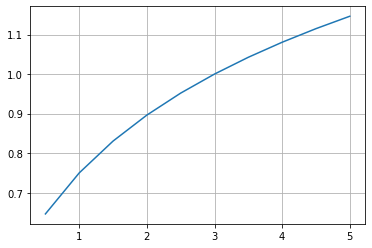

In [540]:
x = [x/2 for x in range(1, 11)]
y = [0.5 + math.log((x+1)**(1/(math.log(3+1)*2))) for x in x]
plt.grid()
plt.plot(x, y)

In [612]:
def evaluate_title(doc_i, query):
    
    query = process_plot(query).split()
    
    article = open("articles/article_"+str(doc_i[0])+".tsv", "r")
    reader = csv.reader(article, delimiter="\t")
    lines = list(reader)
    title = lines[1][0]
    title = process_plot(title)
    title = title.split()
    series = lines[1][1].strip(" ()")
    series = process_plot(series)
    series = series.split()
    for elem in series:
        title.append(elem)
        
    n = len(title)
    
    score = 0
    
    for word in query:
        if word in title:
            score += title.count(word)
    
    if score != 0:
        title_score = 0.5 + math.log((score+1)**(1/(math.log(n+1)*2)))
    else:
        return 0
    
    return title_score
    

In [613]:
def evaluate_ranking(doc_i):
    
    article = open("articles/article_"+str(doc_i[0])+".tsv", "r")
    reader = csv.reader(article, delimiter="\t")
    lines = list(reader)
    ranking = float(lines[1][3])
    ranking_num = int(lines[1][4])
    
    score1 = ranking/5
    
    if ranking_num != 0:
        score2 = 100**(-(4000/ranking_num))
    else:
        score2 = 0
    
    return score1*0.2 + score2*0.8

In [616]:
def advanced_search(query, vocabulary, dictionary, k = 100):
    
    start = time.time()
    
    if query == "":
        res = []
        end = time.time()
        seconds = end - start
        print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
        return
    
    res = aux(query, vocabulary, dictionary)
        
    heap = []
    heapq.heapify(heap)
    
    
    for doc_i in res:
        plot_score = cosine_similarity(doc_i, query)
        title_score = evaluate_title(doc_i, query)
        ranking_score = evaluate_ranking(doc_i)
        score = plot_score*0.4 + title_score*0.4 + ranking_score*0.2
        doc_i[0] = -doc_i[0]
        doc_i.insert(0, score)
        heapq.heappush(heap, doc_i)
    
    end = time.time()
    seconds = (end - start)
    
    
    # Print all the books found
    print('\n\033[30m' + "About " + str(len(res)) + " results (" + str(round(seconds, 3)) + " seconds)\n")
    
    if k < len(heap):
        res = heapq.nlargest(k, heap)
    else:
        res = heapq.nlargest(len(heap), heap)
        
    book_num = 1
    for doc_i in res:
        article = open("articles/article_"+str(-doc_i[1])+".tsv", "r")
        reader = csv.reader(article, delimiter="\t")
        lines = list(reader)
        title = lines[1][0]
        plot = lines[1][6]
        url = lines[1][11]
        print("====== " +'\033[91m' + "Book n." + str(book_num) +'\033[0m' + " ======\n")
        print('\033[1m' + "Title : " + '\033[0m' + title + "\n")
        print('\033[1m' + "Plot : " + '\033[0m' + plot + "\n")
        print('\033[1m' + "url :" + '\033[0m', end = " ")
        print(url + "\n")
        print('\033[1m' + "Similarity : " + '\033[0m' + str(doc_i[0]) + "\n")
        book_num += 1

In [617]:
query = input("Insert query : ")
advanced_search(query, vocabulary, dictionary2)

Insert query : hunger games

About 46 results (0.054 seconds)

====== Book n.1 ======

Title : The Hunger Games

Plot : Could you survive on your own in the wild, with every one out to make sure you don't live to see the morning? In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and one girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV. Sixteen-year-old Katniss Everdeen, who lives alone with her mother and younger sister, regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against